# Importing packages

In [81]:
# Importing the packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_classif
from scipy.stats import chi2_contingency

# Loading in the data

In [36]:
# Loading seperate datasets

# Define file paths
ratings_file = '/Users/femke/Documents/Uni/DSS/Thesis/Data/ml-1m/ratings.dat'
users_file = '/Users/femke/Documents/Uni/DSS/Thesis/Data/ml-1m/users.dat'
movies_file = '/Users/femke/Documents/Uni/DSS/Thesis/Data/ml-1m/movies.dat'

# Load datasets
ratings = pd.read_csv(ratings_file, sep='::', header=None, names=['UserID', 'MovieID', 'Rating', 'Timestamp'], engine='python')
users = pd.read_csv(users_file, sep='::', header=None, names=['UserID', 'Gender', 'Age', 'Occupation', 'Zip-code'], engine='python')
movies = pd.read_csv(movies_file, sep='::', header=None, names=['MovieID', 'Title', 'Genres'], engine='python', encoding='ISO-8859-1')

In [82]:
# Loading in the merged datasets

# Load file with time component
df = pd.read_csv("/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df.csv")

# Load file with time component, categories renamed
df_category = pd.read_csv("/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df_category.csv")

# Load file with time component, movie dummy
df_expanded_movies = pd.read_csv("/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df_expanded_movies.csv")

# Load file with time component, categories renamed, movie dummy
df_expanded_movies_category = pd.read_csv("/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df_expanded_movies_category.csv")

# Load FINAL file with time component, categories renamed, movie dummy, ordered right
df_final = pd.read_csv("/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df_final.csv")

In [43]:
# Merging the seperate datasets
ratings_plus_users = pd.merge(ratings, users, on='UserID')

# Merge the result with movies
df = pd.merge(ratings_plus_users, movies, on='MovieID')

# Change basics

In [45]:
# Splitting 'Timestamp'
df['Timestamp'] = df['Timestamp'].apply(datetime.fromtimestamp)
df['Year'] = df['Timestamp'].dt.year
df['Month'] = df['Timestamp'].dt.month
df['Day'] = df['Timestamp'].dt.day
df['Hour'] = df['Timestamp'].dt.hour
df['Minute'] = df['Timestamp'].dt.minute
df['Second'] = df['Timestamp'].dt.second

In [68]:
# Creating df_category (Occupation and Age in full)

# Create a copy of the dataframe
df_category = df.copy()

# Change the names of the categories for the Age feature
age_mapping = {
    1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44",
    45: "45-49", 50: "50-55", 56: "56+"
}
df_category['Age'] = df_category['Age'].map(age_mapping)

# Change the names of the categories for the Occupation feature
occupation_mapping = {
    0: "Other or not specified", 1: "Academic/educator", 2: "Artist",
    3: "Clerical/admin", 4: "College/grad student", 5: "Customer service",
    6: "Doctor/health care", 7: "Executive/managerial", 8: "Farmer",
    9: "Homemaker", 10: "K-12 student", 11: "Lawyer", 12: "Programmer",
    13: "Retired", 14: "Sales/marketing", 15: "Scientist", 16: "Self-employed",
    17: "Technician/engineer", 18: "Tradesman/craftsman", 19: "Unemployed",
    20: "Writer"
}
df_category['Occupation'] = df_category['Occupation'].map(occupation_mapping)

# Movies dataset exploration

In [48]:
# Separating Release_year from Title

movies['Release_year'] = movies.Title.str.extract("\((\d{4})\)", expand=True).astype(str)

movies['Release_year'] = pd.to_datetime(movies.Release_year, format='%Y')
movies['Release_year'] = movies.Release_year.dt.year
movies['Title'] = movies.Title.str[:-7]

In [49]:
# Separating the Genres
# Unique genres.
genres_unique = pd.DataFrame(movies.Genres.str.split('|').tolist()).stack().unique()
genres_unique = pd.DataFrame(genres_unique, columns=['Genre'])

# Remove old Genres column
movies = movies.join(movies.Genres.str.get_dummies().astype(bool))
movies.drop('Genres', inplace=True, axis=1)

In [50]:
# Merge new movie with other dataset + create time component
df_expanded_movies = pd.merge(ratings_plus_users, movies, on='MovieID')

# Creating time components in merged dataset df
df_expanded_movies['Timestamp'] = df_expanded_movies['Timestamp'].apply(datetime.fromtimestamp)
df_expanded_movies['Year'] = df_expanded_movies['Timestamp'].dt.year
df_expanded_movies['Month'] = df_expanded_movies['Timestamp'].dt.month
df_expanded_movies['Day'] = df_expanded_movies['Timestamp'].dt.day
df_expanded_movies['Hour'] = df_expanded_movies['Timestamp'].dt.hour
df_expanded_movies['Minute'] = df_expanded_movies['Timestamp'].dt.minute
df_expanded_movies['Second'] = df_expanded_movies['Timestamp'].dt.second

In [65]:
# Creating df_expanded_movies_category (Occupation and Age in full + movie dummy)

# Create a copy of the dataframe
df_expanded_movies_category = df_expanded_movies.copy()

# Change the names of the categories for the Age feature
age_mapping = {
    1: "Under 18", 18: "18-24", 25: "25-34", 35: "35-44",
    45: "45-49", 50: "50-55", 56: "56+"
}
df_expanded_movies_category['Age'] = df_expanded_movies_category['Age'].map(age_mapping)

# Change the names of the categories for the Occupation feature
occupation_mapping = {
    0: "Other or not specified", 1: "Academic/educator", 2: "Artist",
    3: "Clerical/admin", 4: "College/grad student", 5: "Customer service",
    6: "Doctor/health care", 7: "Executive/managerial", 8: "Farmer",
    9: "Homemaker", 10: "K-12 student", 11: "Lawyer", 12: "Programmer",
    13: "Retired", 14: "Sales/marketing", 15: "Scientist", 16: "Self-employed",
    17: "Technician/engineer", 18: "Tradesman/craftsman", 19: "Unemployed",
    20: "Writer"
}
df_expanded_movies_category['Occupation'] = df_expanded_movies_category['Occupation'].map(occupation_mapping)

In [66]:
# Sorting df_expanded_movies_category
desired_columns = ['UserID', 'MovieID', 'Rating', 'Timestamp', 'Year', 'Month', 'Day', 'Hour', 'Minute' ,'Gender', 'Age', 'Occupation', 'Zip-code', 
                   'Title', 'Release_year', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 
                   'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                   'Sci-Fi', 'Thriller', 'War', 'Western']

# Now, we can reorder the dataframe and drop the 'Timestamp' column
df_expanded_movies_category = df_expanded_movies_category[desired_columns]

# Preparing final dataframe for use in model

In [53]:
# Creating a temporary df (Occupation in full)

# Change the names of the categories for the Occupation feature

df_temp = df_expanded_movies.copy()

occupation_mapping = {
    0: "Other or not specified", 1: "Academic/educator", 2: "Artist",
    3: "Clerical/admin", 4: "College/grad student", 5: "Customer service",
    6: "Doctor/health care", 7: "Executive/managerial", 8: "Farmer",
    9: "Homemaker", 10: "K-12 student", 11: "Lawyer", 12: "Programmer",
    13: "Retired", 14: "Sales/marketing", 15: "Scientist", 16: "Self-employed",
    17: "Technician/engineer", 18: "Tradesman/craftsman", 19: "Unemployed",
    20: "Writer"
}
df_temp['Occupation'] = df_temp['Occupation'].map(occupation_mapping)

In [54]:
# One-hot encode Gender
df_temp = pd.get_dummies(df_temp, columns=['Gender'], drop_first=True)
df_temp.rename(columns={'Gender_M': 'Male'}, inplace=True)

In [55]:
# Sorting the df_temp
desired_columns = ['UserID', 'MovieID', 'Rating', 'Year', 'Month', 'Day', 'Hour', 'Minute', 'Second' ,'Male', 'Age', 'Occupation', 'Zip-code', 
                   'Title', 'Release_year', 'Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 
                   'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
                   'Sci-Fi', 'Thriller', 'War', 'Western']

# Reorganize df in temporary dataset
df_temp = df_temp[desired_columns]

In [56]:
# One-Hot encode Occupation

# Assuming df_temp is your dataframe
df_temp = pd.get_dummies(df_temp, columns=['Occupation'], drop_first=True)

# Rename the columns to remove the prefix 'Occupation_'
df_temp.columns = [col.replace('Occupation_', '') for col in df_temp.columns]

In [57]:
# Hash trick encoding Zip-code
df_temp['Zip-code'] = df_temp['Zip-code'].apply(lambda x: hash(x) % 10000)  # Modulo to keep the numbers manageable


In [58]:
# Turn df_temp into df_final
df_final = df_temp.copy()

# Saving the files

In [65]:
# Save all dataframes

# Save file with time component
df.to_csv('/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df.csv', index=False)

# Save file with time component, categories renamed
df_category.to_csv('/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df_category.csv', index=False)

# Save file with time component, movie dummy
df_expanded_movies.to_csv('/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df_expanded_movies.csv', index=False)

# Save file with time component, categories renamed, movie dummy
df_expanded_movies_category.to_csv('/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df_expanded_movies_category.csv', index=False)

# Save file with time component, categories renamed, movie dummy, ordered right
df_final.to_csv('/Users/femke/Documents/Uni/DSS/Thesis/Data/ml1m_df_final.csv', index=False)


# EDA

## Distributions

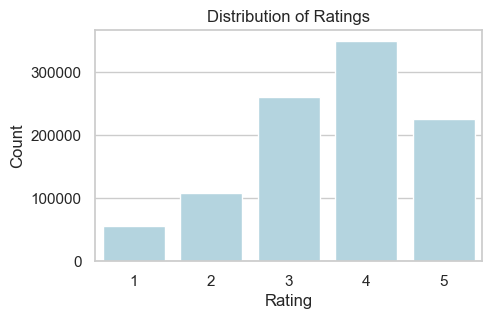

In [60]:
# Distribution of ratings
def plot_rating_distribution(df):
    plt.figure(figsize=(5, 3))
    sns.countplot(x=df['Rating'], color='lightblue')
    plt.title('Distribution of Ratings')
    plt.xlabel('Rating')
    plt.ylabel('Count')
    plt.show()

# Example usage:
plot_rating_distribution(df)

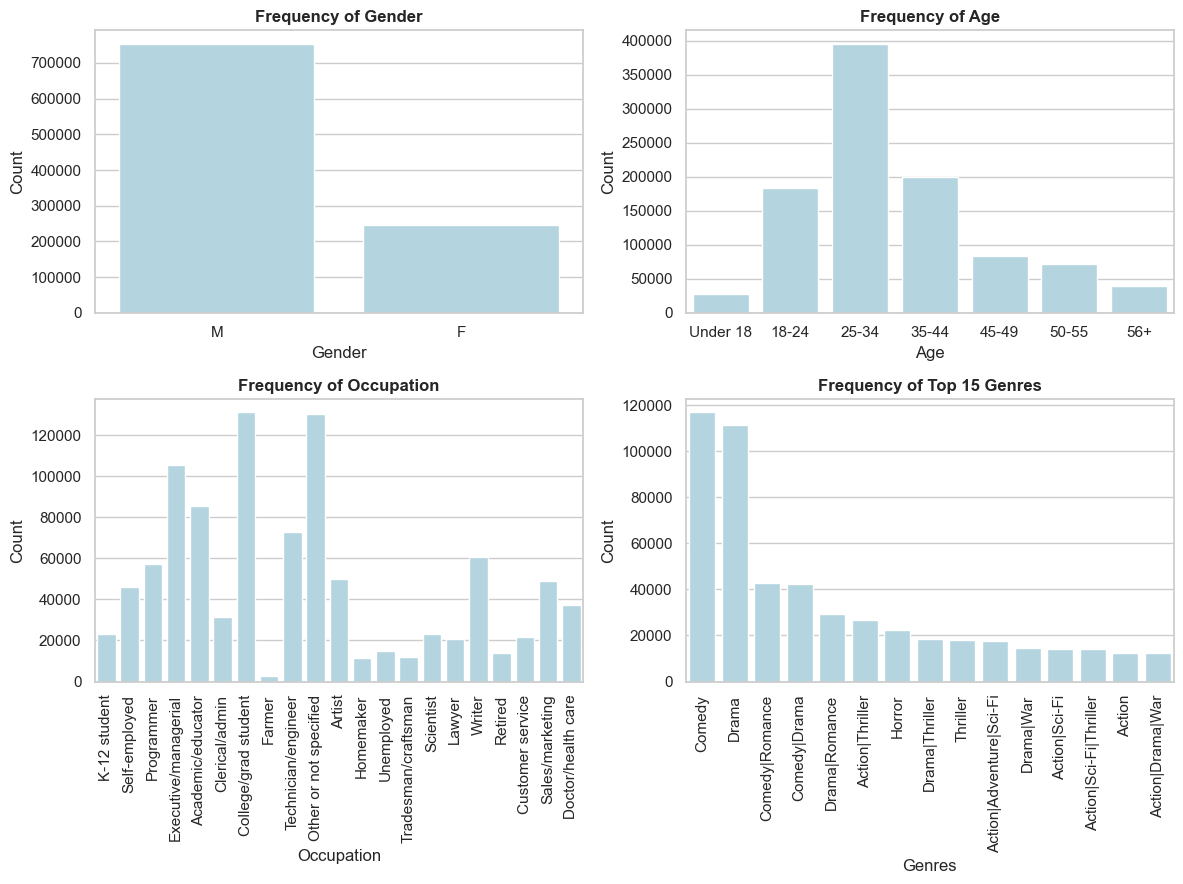

In [70]:
# Distribution of categorical features
# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(12, 9))

# Plot Gender
sns.countplot(ax=axes[0, 0], x=df_category['Gender'], order=df_category['Gender'].value_counts().index, color='lightblue')
axes[0, 0].set_title('Frequency of Gender', fontweight='bold')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_xlabel('Gender')

# Plot Age (ordinal)
age_order = list(age_mapping.values())
sns.countplot(ax=axes[0, 1], x=df_category['Age'], order=age_order, color='lightblue')
axes[0, 1].set_title('Frequency of Age', fontweight='bold')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_xlabel('Age')

# Plot Occupation (ordinal)
sns.countplot(ax=axes[1, 0], x=df_category['Occupation'], color='lightblue')
axes[1, 0].set_title('Frequency of Occupation', fontweight='bold')
axes[1, 0].set_ylabel('Count')
axes[1, 0].set_xlabel('Occupation')
for item in axes[1, 0].get_xticklabels():
    item.set_rotation(90)

# Plot Genres (only the top 15 most popular genres)
top_genres = df_category['Genres'].value_counts().nlargest(15).index
sns.countplot(ax=axes[1, 1], x=df_category[df_category['Genres'].isin(top_genres)]['Genres'], order=top_genres, color='lightblue')
axes[1, 1].set_title('Frequency of Top 15 Genres', fontweight='bold')
axes[1, 1].set_ylabel('Count')
axes[1, 1].set_xlabel('Genres')
for item in axes[1, 1].get_xticklabels():
    item.set_rotation(90)

# Adjust layout
plt.tight_layout()
plt.show()

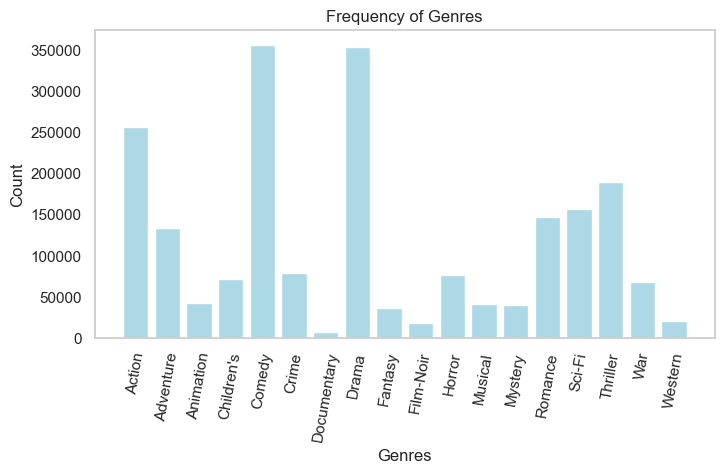

In [79]:
# List of genres
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 
          'Sci-Fi', 'Thriller', 'War', 'Western']

# Frequency of Genres
ratings_count = {}
for genre in genres:
    ratings_count[genre] = df_expanded_movies_category[df_expanded_movies_category[genre] == 1]['Rating'].count()

# Plotting the amount of ratings per genre
plt.figure(figsize=(8, 4))
plt.bar(ratings_count.keys(), ratings_count.values(), color='lightblue')
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Frequency of Genres')
plt.grid(False)
plt.xticks(rotation=80)
plt.show()

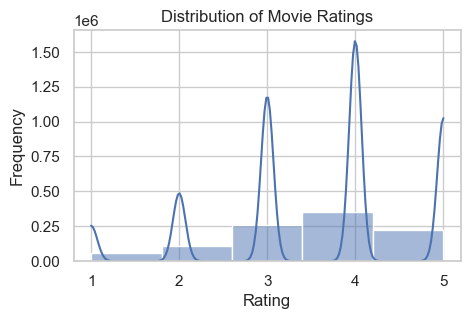

In [72]:
# Visualize the distribution of ratings using histograms and kernel density plots
# Set the aesthetic style of the plots
sns.set(style="whitegrid")

# Create the histogram with KDE plot
plt.figure(figsize=(5, 3))
sns.histplot(df['Rating'], bins=5, kde=True)

# Add titles and labels
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# Show the plot
plt.show()

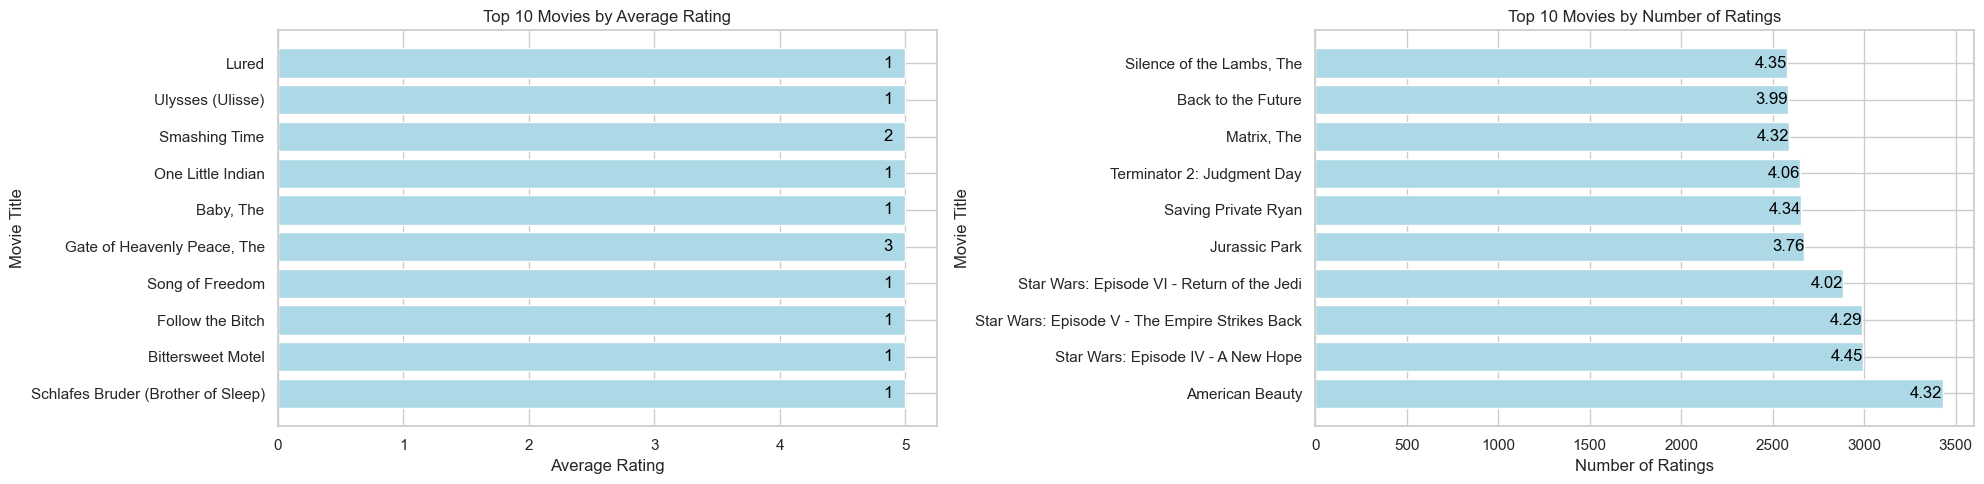

In [73]:
# Calculate the average rating for each movie
average_ratings = df_expanded_movies_category.groupby(['MovieID', 'Title'])['Rating'].mean().reset_index()
average_ratings.columns = ['MovieID', 'Title', 'AverageRating']

# Calculate the number of ratings for each movie
rating_counts = df_expanded_movies_category.groupby(['MovieID', 'Title'])['Rating'].count().reset_index()
rating_counts.columns = ['MovieID', 'Title', 'RatingCount']

# Merge the average ratings and rating counts into a single DataFrame
movie_stats = pd.merge(average_ratings, rating_counts, on=['MovieID', 'Title'])

# Sort the movies by average rating and by the number of ratings
top_movies_by_avg_rating = movie_stats.sort_values(by='AverageRating', ascending=False).head(10)
top_movies_by_rating_count = movie_stats.sort_values(by='RatingCount', ascending=False).head(10)

# Create a 1x2 grid for the plots
fig, axs = plt.subplots(1, 2, figsize=(20, 5))

# Plot the top 10 movies by average rating
bars1 = axs[0].barh(top_movies_by_avg_rating['Title'], top_movies_by_avg_rating['AverageRating'], color='lightblue')
axs[0].set_xlabel('Average Rating')
axs[0].set_ylabel('Movie Title')
axs[0].set_title('Top 10 Movies by Average Rating')
# Add number of ratings inside the bars
for bar, rating_count in zip(bars1, top_movies_by_avg_rating['RatingCount']):
    axs[0].text(bar.get_width() - 0.1, bar.get_y() + bar.get_height()/2, f'{rating_count}', va='center', ha='right', color='black')

# Plot the top 10 movies by number of ratings
bars2 = axs[1].barh(top_movies_by_rating_count['Title'], top_movies_by_rating_count['RatingCount'], color='lightblue')
axs[1].set_xlabel('Number of Ratings')
axs[1].set_ylabel('Movie Title')
axs[1].set_title('Top 10 Movies by Number of Ratings')
# Add average rating inside the bars
for bar, avg_rating in zip(bars2, top_movies_by_rating_count['AverageRating']):
    axs[1].text(bar.get_width() - 0.1, bar.get_y() + bar.get_height()/2, f'{avg_rating:.2f}', va='center', ha='right', color='black')

# Adjust layout
plt.tight_layout()
plt.show()

## Rating per feature

In [74]:
# Group by 'Occupation' and calculate the mean rating
average_rating_per_occupation = df_category.groupby('Occupation')['Rating'].mean()

# Display the result
print(average_rating_per_occupation)

Occupation
K-12 student              3.532675
academic/educator         3.576642
artist                    3.573081
clerical/admin            3.656516
college/grad student      3.536793
customer service          3.537529
doctor/health care        3.661578
executive/managerial      3.599772
farmer                    3.466741
homemaker                 3.656589
lawyer                    3.617371
other or not specified    3.537544
programmer                3.654001
retired                   3.781736
sales/marketing           3.618481
scientist                 3.689774
self-employed             3.596575
technician/engineer       3.613574
tradesman/craftsman       3.530117
unemployed                3.414050
writer                    3.497392
Name: Rating, dtype: float64


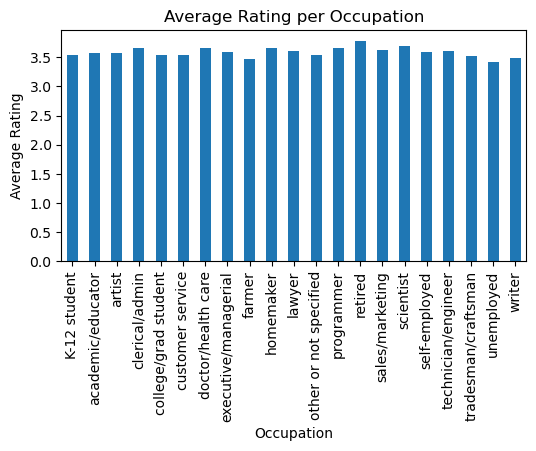

In [78]:
# Plotting the average rating per occupation
plt.figure(figsize=(6, 3))
average_rating_per_occupation.plot(kind='bar')
plt.title('Average Rating per Occupation')
plt.xlabel('Occupation')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

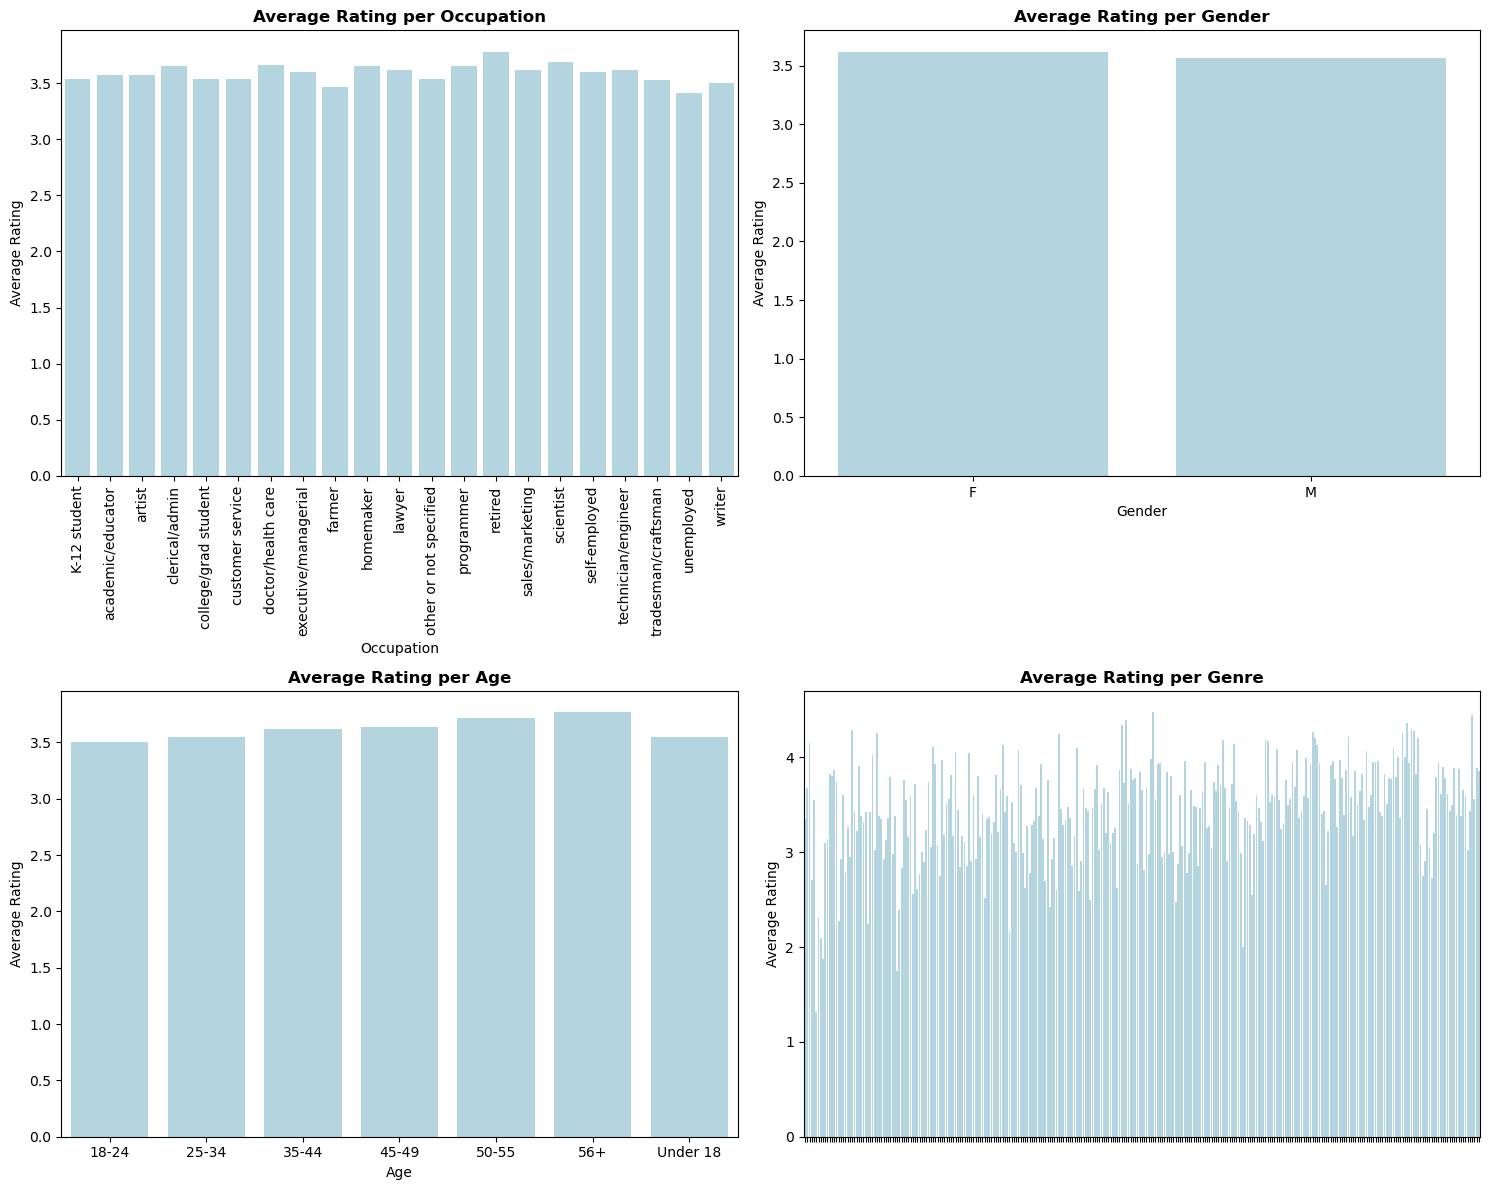

In [82]:
# Calculate the average rating per Occupation, Gender, Age, and Genre
avg_rating_occupation = df_category.groupby('Occupation')['Rating'].mean()
avg_rating_gender = df_category.groupby('Gender')['Rating'].mean()
avg_rating_age = df_category.groupby('Age')['Rating'].mean()
avg_rating_genre = df_category.groupby('Genres')['Rating'].mean()

# Create the 2x2 grid for the plots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot average rating per Occupation
sns.barplot(ax=axes[0, 0], x=avg_rating_occupation.index, y=avg_rating_occupation.values, color='lightblue')
axes[0, 0].set_title('Average Rating per Occupation', fontweight='bold')
axes[0, 0].set_ylabel('Average Rating')
axes[0, 0].set_xlabel('Occupation')
for item in axes[0, 0].get_xticklabels():
    item.set_rotation(90)

# Plot average rating per Gender
sns.barplot(ax=axes[0, 1], x=avg_rating_gender.index, y=avg_rating_gender.values, color='lightblue')
axes[0, 1].set_title('Average Rating per Gender', fontweight='bold')
axes[0, 1].set_ylabel('Average Rating')
axes[0, 1].set_xlabel('Gender')

# Plot average rating per Age
sns.barplot(ax=axes[1, 0], x=avg_rating_age.index, y=avg_rating_age.values, color='lightblue')
axes[1, 0].set_title('Average Rating per Age', fontweight='bold')
axes[1, 0].set_ylabel('Average Rating')
axes[1, 0].set_xlabel('Age')

# Plot average rating per Genre
sns.barplot(ax=axes[1, 1], x=avg_rating_genre.index, y=avg_rating_genre.values, color='lightblue')
axes[1, 1].set_title('Average Rating per Genre', fontweight='bold')
axes[1, 1].set_ylabel('Average Rating')
axes[1, 1].set_xlabel('')
axes[1, 1].set_xticklabels([])

# Adjust layout
plt.tight_layout()
plt.show()

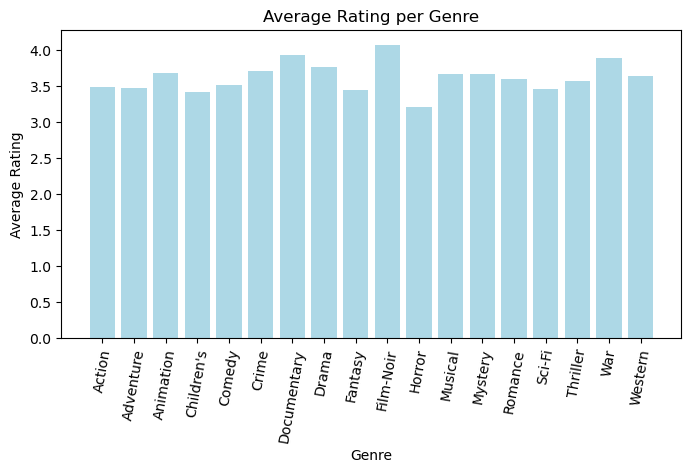

In [145]:
# Rating  per genre
# List of genres
genres = ['Action', 'Adventure', 'Animation', "Children's", 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 
          'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

# Calculate the average rating per genre
average_ratings = {}
for genre in genres:
    genre_ratings = df_expanded_movies_category[df_expanded_movies_category[genre] == 1]['Rating']
    if not genre_ratings.empty:
        average_ratings[genre] = genre_ratings.mean()

# Plotting the average ratings per genre
plt.figure(figsize=(8,4))
plt.bar(average_ratings.keys(), average_ratings.values(), color='lightblue')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.title('Average Rating per Genre')
plt.xticks(rotation=80)
plt.show()


## Number of ratings per movie 

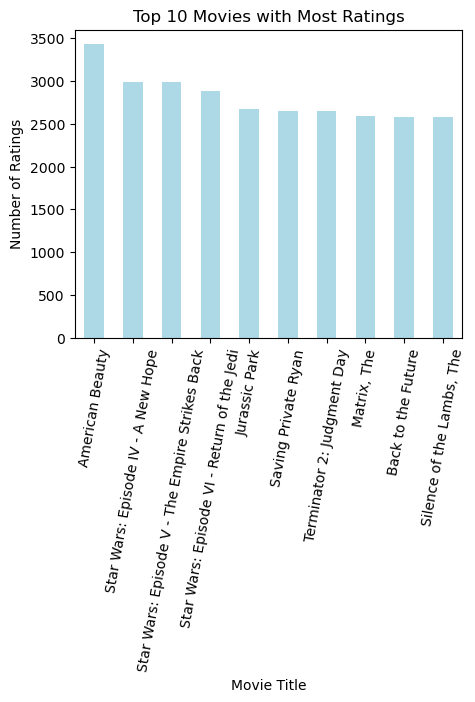

In [153]:
# Calculate the number of ratings per movie
ratings_per_movie = df_expanded_movies.groupby('Title')['Rating'].count().sort_values(ascending=False)

# Plot the top 10 movies with the most ratings
plt.figure(figsize=(5, 4))
ratings_per_movie.head(10).plot(kind='bar', color='lightblue')
plt.title('Top 10 Movies with Most Ratings')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=80)
plt.show()

## Average rating per movie

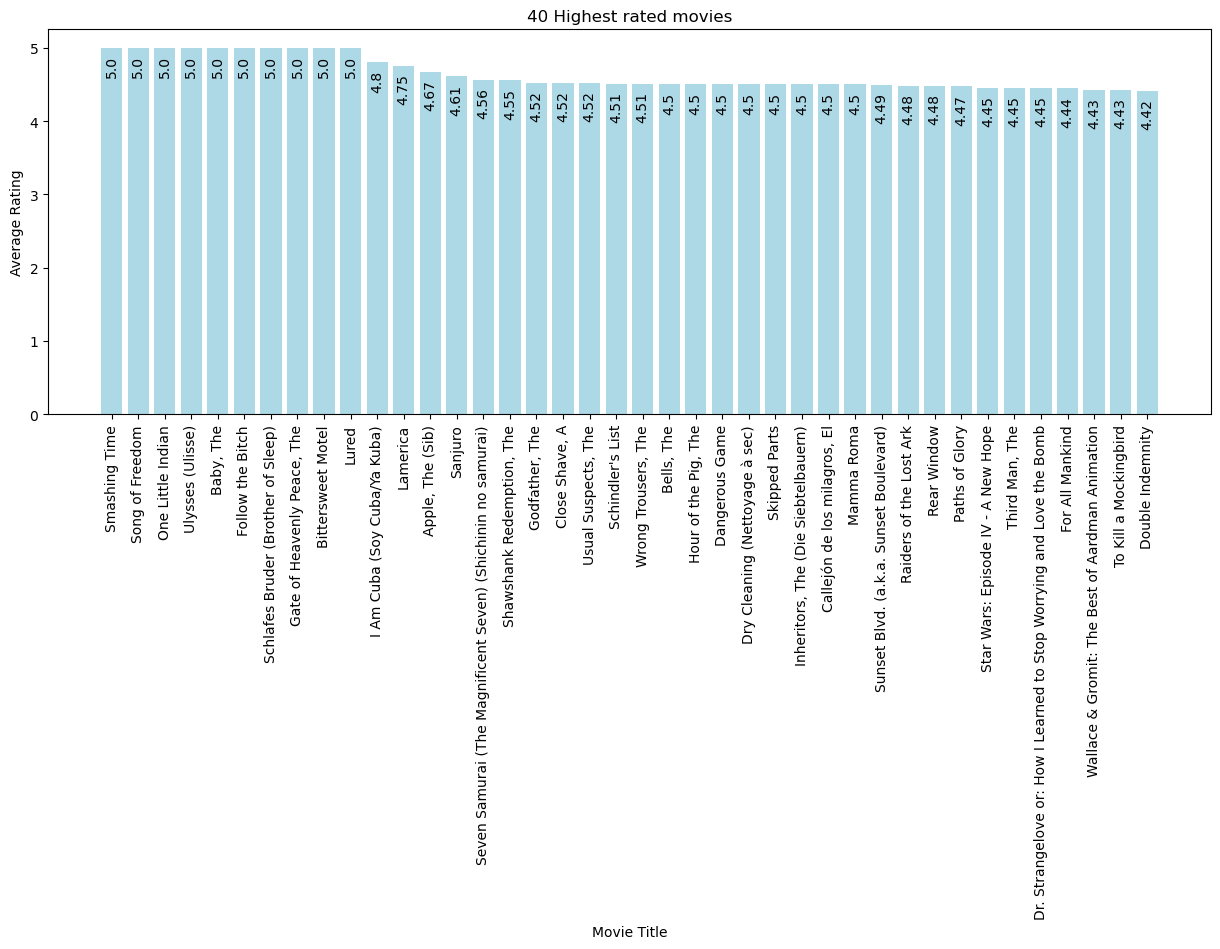

In [164]:
# Calculate the average rating per movie
average_ratings = df_expanded_movies.groupby('Title')['Rating'].mean().sort_values(ascending=False)

# Plot the top 40 movies with the highest average ratings
plt.figure(figsize=(15, 5))
bars = plt.bar(average_ratings.head(40).index, average_ratings.head(40), color='lightblue')

# Add the average rating value inside each bar and rotate by 90 degrees
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval - 0.1, round(yval, 2), ha='center', va='top', rotation=90, color='black')

plt.title('40 Highest rated movies')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

## Correlation between features

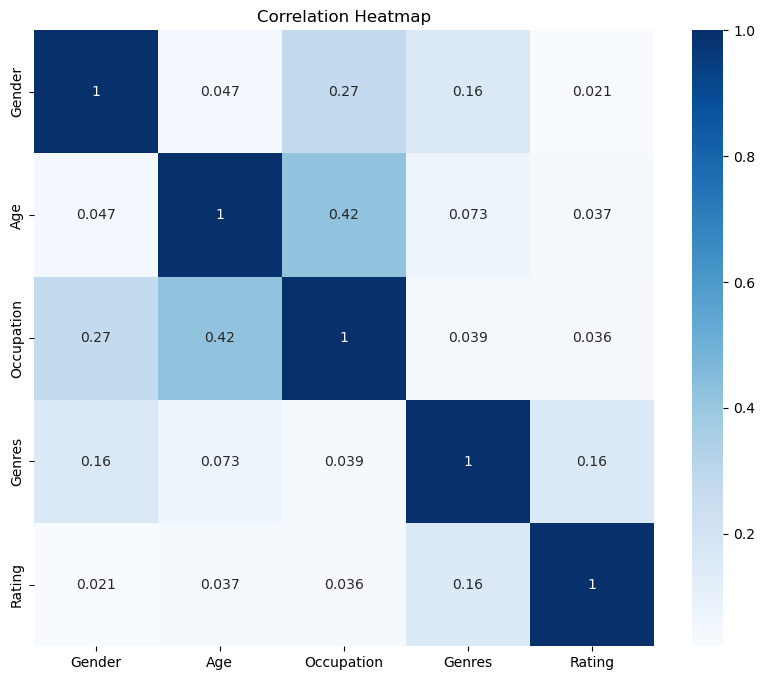

In [102]:

# Function to calculate Cramér's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# List of categorical columns
categorical_columns = ['Gender', 'Age', 'Occupation', 'Genres', 'Rating']

# Create a correlation matrix
corr_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

for col1 in categorical_columns:
    for col2 in categorical_columns:
        corr_matrix.loc[col1, col2] = cramers_v(df_category[col1], df_category[col2])

# Convert to float
corr_matrix = corr_matrix.astype(float)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap')
plt.show()

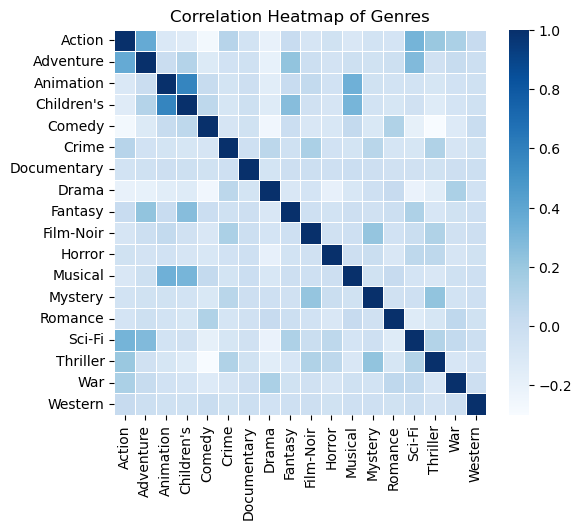

In [172]:
# Extract the genre columns
df_genres = df_expanded_movies_category[genres]

# Calculate the correlation matrix
corr_matrix = df_genres.corr()

# Plot the heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=False, cmap='Blues', linewidths=0.5)
plt.title('Correlation Heatmap of Genres')
plt.show()

## Information gain

In [104]:
# List of categorical columns
categorical_columns = ['Gender', 'Age', 'Occupation', 'Genres', 'Year', 'Month']

# Convert categorical variables to numerical codes
df_encoded = df_category[categorical_columns].apply(lambda x: x.astype('category').cat.codes)

# Calculate the information gain (mutual information) for each categorical variable with respect to the target variable 'Rating'
info_gain = mutual_info_classif(df_encoded, df_category['Rating'], discrete_features=True)

# Create a DataFrame to display the results
info_gain_df = pd.DataFrame({'Feature': categorical_columns, 'Information Gain': info_gain})

# Sort the DataFrame by Information Gain in descending order
info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)

print(info_gain_df)

      Feature  Information Gain
3      Genres          0.046730
1         Age          0.002731
2  Occupation          0.002650
4        Year          0.000720
5       Month          0.000671
0      Gender          0.000229


In [168]:
# Convert categorical variables to numerical codes
df_encoded = df_expanded_movies_category[genres].apply(lambda x: x.astype('category').cat.codes)

# Calculate the information gain (mutual information) for each categorical variable with respect to the target variable 'Rating'
info_gain = mutual_info_classif(df_encoded, df_expanded_movies_category['Rating'], discrete_features=True)

# Create a DataFrame to display the results
info_gain_df = pd.DataFrame({'Feature': genres, 'Information Gain': info_gain})

# Sort the DataFrame by Information Gain in descending order
info_gain_df = info_gain_df.sort_values(by='Information Gain', ascending=False)

print(info_gain_df)

        Feature  Information Gain
7         Drama          0.007718
10       Horror          0.004388
16          War          0.003304
9     Film-Noir          0.002009
0        Action          0.001162
14       Sci-Fi          0.001065
4        Comedy          0.000873
3    Children's          0.000822
1     Adventure          0.000739
5         Crime          0.000583
6   Documentary          0.000451
13      Romance          0.000429
8       Fantasy          0.000302
2     Animation          0.000239
11      Musical          0.000141
12      Mystery          0.000138
15     Thriller          0.000082
17      Western          0.000033


In [67]:
# Basic info merged dataset
# Display basic information about the dataset
print("Basic Information:")
print(df.info())

# Display summary statistics of the dataset
print("\nSummary Statistics:")
print(df.describe())

Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype         
---  ------      --------------    -----         
 0   UserID      1000209 non-null  int64         
 1   MovieID     1000209 non-null  int64         
 2   Rating      1000209 non-null  int64         
 3   Timestamp   1000209 non-null  datetime64[ns]
 4   Gender      1000209 non-null  object        
 5   Age         1000209 non-null  int64         
 6   Occupation  1000209 non-null  int64         
 7   Zip-code    1000209 non-null  object        
 8   Title       1000209 non-null  object        
 9   Genres      1000209 non-null  object        
 10  Year        1000209 non-null  int32         
 11  Month       1000209 non-null  int32         
 12  Date        1000209 non-null  object        
dtypes: datetime64[ns](1), int32(2), int64(5), object(5)
memory usage: 91.6+ MB
None

Summary Statistics:
            

# Extra EDA

In [83]:
df.head()

,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres,Year,Month,Day,Hour,Minute,Second
0,1,1193,5,2000-12-31 23:12:40,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,2000,12,31,23,12,40
1,2,1193,5,2000-12-31 22:33:33,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama,2000,12,31,22,33,33
2,12,1193,4,2000-12-31 00:49:39,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama,2000,12,31,0,49,39
3,15,1193,4,2000-12-30 19:01:19,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama,2000,12,30,19,1,19
4,17,1193,5,2000-12-30 07:41:11,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama,2000,12,30,7,41,11


In [84]:
# Check that no user has rated the same movie twice

# Group by MovieID and UserID and count occurrences
duplicate_counts = df.groupby(['MovieID', 'UserID']).size().reset_index(name='count')

# Filter to find combinations with more than one occurrence
duplicates = duplicate_counts[duplicate_counts['count'] > 1]

print(duplicates)

Empty DataFrame
Columns: [MovieID, UserID, count]
Index: []


In [86]:
df_final.head()

,UserID,MovieID,Rating,Year,Month,Day,Hour,Minute,Second,Male,...,Other or not specified,Programmer,Retired,Sales/marketing,Scientist,Self-employed,Technician/engineer,Tradesman/craftsman,Unemployed,Writer
0,1,1193,5,2000,12,31,23,12,40,False,...,False,False,False,False,False,False,False,False,False,False
1,2,1193,5,2000,12,31,22,33,33,True,...,False,False,False,False,False,True,False,False,False,False
2,12,1193,4,2000,12,31,0,49,39,True,...,False,True,False,False,False,False,False,False,False,False
3,15,1193,4,2000,12,30,19,1,19,True,...,False,False,False,False,False,False,False,False,False,False
4,17,1193,5,2000,12,30,7,41,11,True,...,False,False,False,False,False,False,False,False,False,False


In [87]:
df_final.shape

(1000209, 52)